In [93]:
import pandas as pd
import numpy as np 
import re

from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer#, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import precision_recall_curve

from pyspark.ml.feature import HashingTF, Tokenizer, IDF, StopWordsRemover, CountVectorizer, VectorAssembler
from pyspark.sql import functions as F
from pyspark.sql.functions import explode, lit, col, when

import matplotlib.pyplot as plt

from hashtag_dict import topic_dict

from CustomTransformers import *
from Evaluation import *
from ClassifierAnalyzer import *
from FeatureExtraction import *

# Review Previous Work

### Class Definitions

Changes to previous classes:

* add validation as described in the paper. add a split in data to get validation data (75% - 85% splits following previous implementation)
* remove tweets containing train hashtags from validation and test data
* remove tweets without hashtags from (test?) data
* downsample based on pos/neg sample ratio to achieve 50/50 ratio(previously hardcoded 0.001)

In [4]:
def filter_data(data, terms=[], hashtags=None, users=None, locs=None, mentions=None):
        terms_filter = [re.sub(r'(.*)', r'\\b\1\\b', term) for term in terms]
        terms_regex = '|'.join(terms_filter)
        filtered_data = data.loc[data['term'].str.contains(terms_regex)]
        
        if hashtags != None:
            hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in hashtags]
            hashtags_regex = '|'.join(hashtags_filter)
            hashtags_filtered = data.loc[data['hashtag'].str.contains(hashtags_regex)]
            filtered_data = pd.concat([filtered_data, hashtags_filtered])

        if users != None:
            users_filter = [re.sub(r'(.*)', r'\\b\1\\b', user) for user in users]
            users_regex = '|'.join(users_filter)
            users_filtered = data.loc[data['from_user'].str.contains(users_regex)]
            filtered_data = pd.concat([filtered_data, users_filtered])

        if locs != None:
            locs_filter = [re.sub(r'(.*)', r'\\b\1\\b', loc) for loc in locs]
            locs_regex = '|'.join(locs_filter)
            locs_filtered = data.loc[data['location'].str.contains(locs_regex)]
            filtered_data = pd.concat([filtered_data, locs_filtered])

        if mentions != None:
            mentions_filter = [re.sub(r'(.*)', r'\\b\1\\b', mention) for mention in mentions]
            mentions_regex = '|'.join(mentions_filter)
            mentions_filtered = data.loc[data['mention'].str.contains(mentions_regex)]
            filtered_data = pd.concat([filtered_data, mentions_filtered])
     
        return filtered_data.drop_duplicates()
    
class API:
    def __init__(self, directory, frac=1, seed=123):
        if frac < 1:
            self.data = spark.read.parquet(directory).sample(False, frac, seed)
        else:
            self.data = spark.read.parquet(directory)
          
    def get_raw_data(self):
         return self.data

    def get_filtered_data(self, terms=[], hashtags=None, users=None, locs=None, mentions=None):   
        return filter_data(self.data, terms, hashtags, users, locs, mentions)
    
    
class DataPreprocessor():
    def __init__(self, data, topic, load_labled=False, filter_empty_hashtags=False):
        if filter_empty_hashtags == True:
            self.data = data.filter(col("hashtag") != "empty_hashtag")
        else:
            self.data = data

        if load_labled == True:
            labled_dir = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/" + topic
            pos_dir = labled_dir + "/pos"
            topical_tweet_ids = spark.read.parquet(pos_dir)
            topical_tweets = topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(1))
            
            neg_dir = labled_dir + "/neg"
            non_topical_tweet_ids = spark.read.parquet(neg_dir).sample(False, 0.1, 123)
            non_topical_tweets = non_topical_tweet_ids.join(self.data, "tweet_id").withColumn("label", lit(0))

            self.labled_data = topical_tweets.union(non_topical_tweets)
        else:
            self.labled_data = None

        tokenizer = Tokenizer(inputCol="hashtag", outputCol="each_hashtag")
        hashtags_df = tokenizer.transform(self.data)

        hashtag = hashtags_df.select("tweet_id","create_time","each_hashtag")
        self.hash_exploded = hashtag.withColumn('each_hashtag', explode('each_hashtag'))
    
    def get_labled_data(self, topic):
        if self.labled_data == None:
            topic_lables = topic_dict[topic]

            topical_ids = self.hash_exploded.select(self.hash_exploded.tweet_id)\
                                                    .where(self.hash_exploded.each_hashtag\
                                                            .isin(topic_lables))\
                                                    .distinct().cache()

            labled_topical = topical_ids.withColumn("topical", lit(1))
            self.labled_data = self.data.join(labled_topical, self.data.tweet_id == labled_topical.tweet_id, "left")\
                                                      .select(self.data.create_time,\
                                                             self.data.from_id,\
                                                             self.data.from_user,\
                                                             self.data.hashtag,\
                                                             self.data.location,\
                                                             self.data.mention,\
                                                             self.data.tweet_id,\
                                                             self.data.term,\
                                                              F.when(labled_topical.topical == 1, 1.0)\
                                                                .otherwise(0.0).alias("label"))
        return self.labled_data
    
    def get_num_of_positvies(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.where(col("label") == 1.0).count()
    
    def get_data_size(self):
        if self.labled_data == None:
            return 0
        
        return self.labled_data.count()
        
    def temporal_split(self, topic, balance_data=True, seed=0, remove_topic_hashtags=False):
        topic_lables = topic_dict[topic]
        labled_data = self.get_labled_data(topic)
        tweet_labels = labled_data.select("tweet_id", "label")
        
        df_birthday = self.hash_exploded.join(tweet_labels,\
                                 self.hash_exploded.tweet_id == tweet_labels.tweet_id,\
                                 "inner").select(self.hash_exploded.create_time,\
                                                 self.hash_exploded.each_hashtag,\
                                                 self.hash_exploded.tweet_id)
        
        ## Find out the "birthday", or the earliest appearing time of each hashtag. 
        ## (add an extra column of 1 to mark as topical, will be used in a join later)
        ordered_hashtag_set = df_birthday.\
                              groupby("each_hashtag").\
                              agg({"create_time": "min"}).\
                              orderBy('min(create_time)', ascending=True).\
                              withColumnRenamed("min(create_time)", "birthday").\
                              where(df_birthday.each_hashtag.isin(topic_lables)).cache()
                            
        time_span = ordered_hashtag_set.count()

        train_valid_split_time = np.floor(np.multiply(time_span, 0.75)).astype(int)
        valid_test_split_time = np.floor(np.multiply(time_span, 0.85)).astype(int)

        # Converting to Pandas for random row access.
        pd_ordered_hashtag_set = ordered_hashtag_set.toPandas()
        
        # locate the timestamp of the cutoff point. Will be used later to split Dataframe.
        train_valid_time = pd_ordered_hashtag_set.iloc[train_valid_split_time]['birthday']
        valid_test_time = pd_ordered_hashtag_set.iloc[valid_test_split_time]['birthday']
    
        training_set = labled_data.where(col("create_time") <= train_valid_time)
        validation_set = labled_data.where((col("create_time") > train_valid_time) \
                                           & (col("create_time") <= valid_test_time))
        test_set = labled_data.where(col("create_time") > valid_test_time)
        
        if remove_topic_hashtags == True:
            train_hashtags = pd_ordered_hashtag_set[:train_valid_split_time]['each_hashtag'].tolist()
            train_valid_hashtags = pd_ordered_hashtag_set[:valid_test_split_time]['each_hashtag'].tolist()
            
            train_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_hashtags]
            train_hashtags_regex = '|'.join(train_hashtags_filter)
            invalid_validation_ids = (validation_set.filter(validation_set['hashtag'].rlike(train_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
            validation_set = validation_set.where(~col("tweet_id").isin(invalid_validation_ids))
            
            train_valid_hashtags_filter = [re.sub(r'(.*)', r'\\b\1\\b', hashtag) for hashtag in train_valid_hashtags]
            train_valid_hashtags_regex = '|'.join(train_valid_hashtags_filter)
            invalid_test_ids = (test_set.filter(test_set['hashtag'].rlike(train_valid_hashtags_regex)))\
                                        .select("tweet_id").distinct().rdd.flatMap(lambda x: x).collect()
                
            test_set = test_set.where(~col("tweet_id").isin(invalid_test_ids))
        
        if balance_data == True:
            train_pos_count = training_set.where(col("label") == 1).count()
            train_neg_count = training_set.count() - train_pos_count
            train_pos_neg_ratio = float(train_pos_count) / train_neg_count
            
            training_set = training_set.sampleBy("label", fractions={0.0: train_pos_neg_ratio, 1.0: 1}, seed=seed)
            
            valid_pos_count = validation_set.where(col("label") == 1).count()
            valid_neg_count = validation_set.count() - valid_pos_count
            valid_pos_neg_ratio = float(valid_pos_count) / valid_neg_count
            
            validation_set = validation_set.sampleBy("label", fractions={0.0: valid_pos_neg_ratio, 1.0: 1}, seed=seed)
            
        return training_set, validation_set, test_set

### Change Classifier Pipeline:

* filter test data (not train+valid)

In [168]:
class TestFramework:
    def __init__(self, train, valid, test):
        self.train = train
        self.valid = valid
        self.test = test
                
        print("Initializing Classifier....")
        self.pipeline = self.initialize_pipeline()
        print("Complete!")
        self.analyzer = ClassifierAnalyzer(self.pipeline)
        
    def initialize_pipeline(self):        
        train_features = self.train.drop('label', axis=1)
        train_target = self.train['label']
        
        validation_features = self.valid.drop('label', axis=1)
        valid_target = self.valid['label']
        
        feature_transformer = FeatureUnion(
                                    transformer_list=[
                                        ('term', Pipeline([
                                            ('selector', ItemSelector(key='term')),
                                            ('count', CountVectorizer(stop_words='english', min_df=5)),
                                        ])),

                                        ('hashtag', Pipeline([
                                            ('selector', ItemSelector(key='hashtag')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ])),

                                        ('user', Pipeline([
                                            ('selector', ItemSelector(key='from_user')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ])),

                                        ('location', Pipeline([
                                            ('selector', ItemSelector(key='location')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ])),

                                        ('mention', Pipeline([
                                            ('selector', ItemSelector(key='mention')),
                                            ('count', CountVectorizer(min_df=5)),
                                        ]))
                                    ])
            
        train_valid = pd.concat([train_features, validation_features])
        train_valid_target = pd.concat([train_target, valid_target])

        train_valid_transformed = feature_transformer.fit_transform(train_valid)
        
        train_transformed = feature_transformer.transform(train_features)
        valid_transformed = feature_transformer.transform(validation_features)
        
        # select c for best accuracy
        Cs = [100] #[0.01, 0.1, 1, 10, 100] TEMP
        best_classifier = None
        best_score = 0
        
        for c in Cs:
            classifier = LogisticRegression(C=c)
            classifier.fit(train_transformed, train_target)    
            c_score = classifier.score(valid_transformed, valid_target)
            if c_score > best_score:
                best_classifier = classifier
                best_score = c_score
               
        return Pipeline(steps=[('features', feature_transformer), ('classifier', best_classifier)])

    def get_pipeline(self):
        return self.pipeline
    
    def get_top_features(self, k):
        top_terms, top_hashtags, top_users, top_locs, top_mentions = self.analyzer.get_top_features(k)
        
        print("Top Terms: ", top_terms)
        print("Top Hashtags: ", top_hashtags)
        print("Top Users: ", top_users)
        print("Top Locations: ", top_locs)
        print("Top Mentions: ", top_mentions)
    
    def get_top_features(self, k):
        return self.analyzer.get_top_features(k)
    
    def get_filtered_test_data(self, k, verbose=False):
        top_terms, top_hashtags, top_users, top_locs, top_mentions = self.get_top_features(k)
        
        if verbose == True:
            print("Top Terms: ", top_terms)
            print("Top Hashtags: ", top_hashtags)
            print("Top Users: ", top_users)
            print("Top Locations: ", top_locs)
            print("Top Mentions: ", top_mentions)

        data = filter_data(self.test, top_terms, top_hashtags, top_users, top_locs, top_mentions)
        
        return data
    
    def get_filtered_data_by_index(self, indexes):
        features = get_feature_by_index(self.pipeline, indexes)
        
        terms = features[features.Type == "Term"].Feature.tolist()
        hashtags = features[features.Type == "Hashtag"].Feature.tolist()
        users = features[features.Type == "User"].Feature.tolist()
        locs = features[features.Type == "Location"].Feature.tolist()
        mentions = features[features.Type == "Mention"].Feature.tolist()
        
        data = filter_data(self.test, terms, hashtags, users, locs, mentions)
        
        return data
        
    def get_baseline_performance(self):
        test_features = self.test.drop('label', axis=1)
        test_target = self.test['label']

        predictions = self.pipeline.predict_proba(test_features)[:, 1]
        
        return model_evaluation_summary(test_target, predictions)
    
    def run_config_by_index(self, indexes):
        test = self.get_filtered_data_by_index(indexes)
        
        test_features = test.drop('label', axis=1)
        test_target = test['label']

        predictions = self.pipeline.predict_proba(test_features)[:, 1]
        
        return model_evaluation_summary(test_target, predictions)
     
    def run_configs(self, configs=[]):
        pipelines = []
        positive_counts = []
        total_counts = []
        aveps = []
        prec_recall = []
        
        for config in configs:
            test = self.get_filtered_test_data(config)
            positive_counts.append(len(test[test.label == 1]))     
            total_counts.append(len(test))
            
            test_features = test.drop('label', axis=1)
            test_target = test['label']
            
            predictions = self.pipeline.predict_proba(test_features)[:, 1]
            aveps.append(average_precision_score(test_target, predictions))

            precision, recall, _ = precision_recall_curve(test_target, predictions)
            prec_recall.append([precision, recall])
            
        return positive_counts, total_counts, pipelines, aveps, prec_recall

In [6]:
directory = "/mnt/66e695cd-1a0c-4e3b-9a50-55e01b788529/Training_data/Staging_final/"
api = API(directory)
raw_data = api.get_raw_data()

In [5]:
p = spark.read.parquet("/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/Natr_Disaster/pos")

In [ ]:
no_hashtag_count = raw_data.where(col("hashtag") == "empty_hashtag").count()
total_count = raw_data.count()

In [ ]:
print(float(no_hashtag_count)/total_count)

80% of the tweets do not contain hashtags so it is not very ideal to drop all of them. 

In [ ]:
output_directory = "/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/labeled_data/"
topic = "Natr_Disaster"

dp = DataPreprocessor(raw_data)
labled_data = dp.get_labled_data(topic).select("tweet_id", "label")

In [ ]:
positives = labled_data.where(col('label') == 1).select("tweet_id")
negatives = labled_data.where(col('label') == 0).select("tweet_id")

(~88k positives)

In [ ]:
pos_dir = output_directory + topic + "/pos" 
positives.write.save(pos_dir, format="parquet")

In [ ]:
neg_dir = output_directory + topic + "/neg"
negatives.write.save(neg_dir, format="parquet")

# Store and Load Splitted Labeled Data

### (CSV SAVE)
[

TODO: 
* Validation balanced before removing train hashtags. must run and store again
* Investigate NaN Values

]

Store Splitted and labeled data as csv to be read easily and fast by pandas:

In [14]:
dp = DataPreprocessor(raw_data, "Natr_Disaster", load_labled=True, filter_empty_hashtags=True)

In [76]:
train, valid, test = dp.temporal_split("Natr_Disaster", remove_topic_hashtags=True)

In [79]:
test.count()

3947513

In [80]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Natr_Disaster"

train_pd = train.toPandas()
train_pd.to_csv(temporal_split_directory + topic + "/training.csv", encoding='utf-8', index=False)

In [81]:
valid_pd = valid.toPandas()
valid_pd.to_csv(temporal_split_directory + topic + "/validation.csv", encoding='utf-8', index=False)

In [82]:
test_pd = test.sample(False, 0.3, 123).toPandas()
test_pd.to_csv(temporal_split_directory + topic + "/test.csv", encoding='utf-8', index=False)

### (CSV LOAD)

In [7]:
temporal_split_directory = '/mnt/1e69d2b1-91a9-473c-a164-db90daf43a3d/splitted_data/'
topic = "Natr_Disaster"

train_pd = pd.read_csv(temporal_split_directory + topic + "/training.csv").dropna()
validation_pd = pd.read_csv(temporal_split_directory + topic + "/validation.csv").dropna()
test_pd = pd.read_csv(temporal_split_directory + topic + "/test.csv").dropna()

/usr/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Test Classifier

In [169]:
tf = TestFramework(train_pd, validation_pd, test_pd)

Initializing Classifier....
Complete!


In [171]:
baseline_patk, baseline_ratk, baseline_avep, baseline_prec_recall = tf.get_baseline_performance()

In [183]:
configs = [[50, 50, 50, 50, 50]]
positive_counts, total_counts, pipelines, aveps, prec_recall = tf.run_configs(configs)

# GUROBI

## [Cell Coverage Example](http://examples.gurobi.com/cell-tower-coverage/)

In [9]:
from gurobipy import *

In [27]:
# Problem Data
# Population in each region
pop = [523, 690, 420, 1010, 1200, 850, 400, 1008, 950]
# Regions covered by each tower
sites = [[0,1,5], [0,7,8], [2,3,4,6], [2,5,6], [0,2,6,7,8], [3,4,8]]
# Cost to build tower (in millions of dollars)
cost = [4.2, 6.1, 5.2, 5.5, 4.8, 9.2]
# Allocated budget (in millions of dollars)
budget = 20

numR = len(pop) # Number of regions
numT = len(sites) # Number of sites for towers

m = Model()

t = {} # Binary variables for each tower
r = {} # Binary variable for each region

for i in range(numT):
    t[i] = m.addVar(vtype=GRB.BINARY, name="t%d" % i)

for j in range(numR):
    r[j] = m.addVar(vtype=GRB.BINARY, name="r%d" % j)

m.update()

for j in range(numR):
    m.addConstr(quicksum(t[i] for i in range(numT) if j in sites[i]) >= r[j])

m.addConstr(quicksum( cost[i]*t[i] for i in range(numT) ) <= budget)

m.setObjective(quicksum( pop[j]*r[j] for j in range(numR) ), GRB.MAXIMIZE)

m.optimize()

Optimize a model with 10 rows, 15 columns and 36 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+00]
  Objective range  [4e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 2e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 4 rows and 5 columns
Presolve time: 0.00s
Presolved: 6 rows, 10 columns, 21 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: objective 7.051000e+03, 1 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7051.0000000 7051.00000  0.00%     -    0s

Explored 0 nodes (1 simplex iterations) in 0.01 seconds
Thread count was 32 (of 40 available processors)

Solution count 2: 7051 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.051000000000e+03, best bound 7.0510

We can Model the API query problem similarly. For a basic implementation, we should define a list like sites which indicates which tweets are covered by each feature.
Since our priority is to cover the maximum number of positive tweets, we will use only the positive set initially.

In [12]:
topical_tweets = test_pd[test_pd.label == 1]

pipeline = tf.get_pipeline()
positive_set = pipeline.named_steps['features'].transform(topical_tweets)

In [112]:
num_tweets = positive_set.shape[0]
num_features = positive_set.shape[1]

feature_coverage = []
top_coverages = []
max_coverage_indexes = []

for i in range(num_features):
    coverage = positive_set[:, i].nonzero()[0]
    if len(coverage) > 50:
        top_coverages.append(len(coverage))
        max_coverage_indexes.append(i)
    feature_coverage.append(coverage)

In [144]:
get_feature_by_index(pipeline, max_coverage_indexes, top_coverages)

,Feature,Type,Coverage
0,2014,Term,51
1,ago,Term,63
2,amp,Term,245
3,army,Term,84
4,california,Term,104
5,check,Term,54
6,flood,Term,64
7,floods,Term,70
8,gt,Term,54
9,help,Term,130


empty_location and empty_mention cannot be used in the actual API. even if they could be used, they will retrieve a lot of non-topical tweets which is not desirable. therefore remove them from the problem here:

In [114]:
len(feature_coverage)

22716

In [115]:
empty_loc_index, empty_mention_index = get_empty_feature_indexes(pipeline)
del(feature_coverage[empty_loc_index])
del(feature_coverage[empty_mention_index-1])

In [116]:
len(feature_coverage)

22714

In [64]:
feature_coverage[:20]

[array([], dtype=int32),
 array([], dtype=int32),
 array([1929], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([2052], dtype=int32),
 array([], dtype=int32),
 array([1415, 2839], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([ 471,  613, 1350, 2044, 2286, 2413, 2487, 2506, 2569, 2585, 2686,
        2913, 2964], dtype=int32),
 array([229, 753], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([2592, 2983], dtype=int32),
 array([132, 527, 738], dtype=int32),
 array([], dtype=int32),
 array([], dtype=int32),
 array([1087, 2488], dtype=int32),
 array([], dtype=int32)]

## Max Cover Formulation

Now that we have the coverages for each feature, let's try solving max cover using gurobi:

![](maxcover_formulation.png)

In [118]:
# Number of features selected
k = 50

num_features = len(feature_coverage)
# num_tweets : Number of Tweets
# feature_coverage: tweets covered by each feature

m = Model()

f = {} # Binary variable for each feature
t = {} # Binary variables for each tweet

for i in range(num_features):
    f[i] = m.addVar(vtype=GRB.BINARY, name="f%d" % i)

for j in range(num_tweets):
    t[j] = m.addVar(vtype=GRB.BINARY, name="t%d" % j)

m.update()

for j in range(num_tweets):
    m.addConstr(quicksum(f[i] for i in range(num_features) if j in feature_coverage[i]) >= t[j])

m.addConstr(quicksum(f[i] for i in range(num_features)) <= k)

m.setObjective(quicksum(t[j] for j in range(num_tweets)), GRB.MAXIMIZE)

m.optimize()

Optimize a model with 3291 rows, 26004 columns and 53658 nonzeros
Variable types: 0 continuous, 26004 integer (26004 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 327 rows and 20463 columns
Presolve time: 0.10s
Presolved: 2964 rows, 5541 columns, 26458 nonzeros
Variable types: 0 continuous, 5541 integer (5541 binary)

Root relaxation: objective 3.158000e+03, 1088 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    3158.0000000 3158.00000  0.00%     -    0s

Explored 0 nodes (1088 simplex iterations) in 0.19 seconds
Thread count was 32 (of 40 available processors)

Solution count 2: 3158 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective

In [123]:
model_vars = m.getVars()[:num_features]
selected_features_index = []

for i in range(len(model_vars)):
    if model_vars[i].X > 0:
        selected_features_index.append(i)

In [161]:
get_feature_by_index(pipeline, selected_features_index)

,Feature,Type
0,amp,Term
1,damage,Term
2,day,Term
3,earthquake,Term
4,family,Term
5,flood,Term
6,good,Term
7,help,Term
8,hurricane,Term
9,indian,Term


In [176]:
maxcover_patk, maxcover_ratk, maxcover_avep, maxcover_prec_recall = tf.run_config_by_index(selected_features_index)

In [181]:
max_cover_filtered_data = tf.get_filtered_data_by_index(selected_features_index)

## Filtered Data Statistics

### By Top Weighted Classifier Coefficients (K = 50 from each feature type (term, hashtag, user, location, mention))

In [193]:
total_positives = len(test_pd[test_pd.label == 1])
total_count = len(test_pd)

In [194]:
print("Total Tweets Retrieved = {0}".format(total_counts[0]))
print("Ratio of Tweets Retrieved = {:0.2f}".format((float)(total_counts[0]) / total_count))


print("Topical Tweets Retrieved = {0}".format(positive_counts[0]))
print("Topcial Tweets Recall = {:0.2f}".format((float)(positive_counts[0]) / total_positives))

Total Tweets Retrieved = 26139
Ratio of Tweets Retrieved = 0.02
Topical Tweets Retrieved = 866
Topcial Tweets Recall = 0.26


### By Max Coverage Model Solution (K = 50 total features)

In [213]:
print("Total Tweets Retrieved = {0}".format(len(max_cover_filtered_data)))
print("Ratio of Tweets Retrieved = {:0.4f}".format((float)(len(max_cover_filtered_data)) / total_count))

pos_retrieved = len(max_cover_filtered_data[max_cover_filtered_data.label == 1])
print("Topical Tweets Retrieved = {0}".format(3158))
print("Topcial Tweets Recall = {:0.2f}".format((float)(3158) / total_positives))

Total Tweets Retrieved = 1183128
Ratio of Tweets Retrieved = 0.9999
Topical Tweets Retrieved = 3158
Topcial Tweets Recall = 0.96


# Classifier Performance

In [218]:
print("Baseline AveP = {:0.4f}".format(baseline_avep))
print("Top Weighted AveP = {:0.4f}".format(aveps[0]))
print("Max Cover AveP = {:0.4f}".format(maxcover_avep))

Baseline AveP = 0.6836
Top Weighted AveP = 0.7814
Max Cover AveP = 0.6836


In [229]:
weighted_recall_scaled = ((float)(positive_counts[0]) / total_positives) * prec_recall[0][1] 
weighted_maxcover_recall_scaled = ((float)(3158) / total_positives) * maxcover_prec_recall[1]

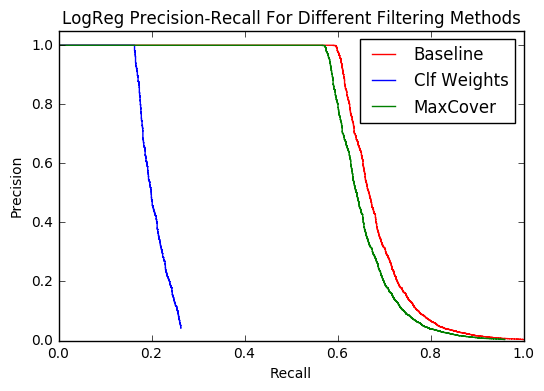

In [241]:
colors = ['r', 'b', 'g', 'k', 'm']
k = ('w/o hashtags', 'w/o users', 'w/o location', 'w/o mention', 'All Selected')

plt.step(baseline_prec_recall[1], baseline_prec_recall[0], color=colors[0], label="Baseline")
plt.step(weighted_recall_scaled, prec_recall[0][0], color=colors[1], label="Clf Weights")
plt.step(weighted_maxcover_recall_scaled, maxcover_prec_recall[0], color=colors[2], label="MaxCover")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=1)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('LogReg Precision-Recall For Different Filtering Methods')
plt.show()